##Summary

*   There should be 81 participants in total
*   Third stage analysis
  * We calculate different correlations in "Third stage analysis". One is the correlation between the participant's rating and all that they see on display in stage 3. The goal of this analysis is to ensure that participants are seeing different responses. i.e., that there is a lower correlation than control. rounded_pearson {'corr': 0.311, 'p': '2.563e-10', 'ci': (0.219, 0.398)}
  * For subsets of followed and not followed, this is the correlation between the individuals's rating and the ratings given by who they followed or not followed.
  * Calculating $\rho$ between $F_{i}$ and the initial Likert rating of the participant, rounded_pearson {'corr': 0.503, 'p': '3.457e-27', 'ci': (0.426, 0.573)}
  * With updated belief, $\rho$ is 0.519 (p: 2.659e-29) [CI: 0.444, 0.587]
* Second stage analysis
  * Correlation between initial response and mean social signal shows is used to see whether what individuals see from their peers is different in both conditions rounded_pearson {'corr': 0.178, 'p': '3.313e-04', 'ci': (0.082, 0.271)}
  * Correlation between the difference is {'corr': 0.31, 'p': '2.140e-10', 'ci': (0.219, 0.396)}
  * Considering only those that changed their answers, {'corr': 0.622, 'p': '2.140e-10', 'ci': (0.493, 0.725)}
* Per person analysis focuses on the analysis of likert differences per person across all rounds.
* Isolation network - People that were not followed in each of the rounds
* Influencer network - People that were most followed per game
* De-influencer network - People that were least followed in each game

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import re
import os
import math

import statistics
from scipy import stats

In [ ]:
def calculate_ci(correlation, n, alpha=0.05):
    z_value = stats.norm.ppf(1 - alpha / 2)
    ci = z_value * np.sqrt(1 / (n - 3))
    lower_bound = np.tanh(np.arctanh(correlation) - ci)
    upper_bound = np.tanh(np.arctanh(correlation) + ci)
    return lower_bound, upper_bound

In [ ]:
def round_values(dictionary, decimal_places=3):
    rounded_dict = {}
    for key, value in dictionary.items():
        if isinstance(value, float):
            # Check if the value is a p-value and format it accordingly
            if key == 'p':
                rounded_dict[key] = "{:.{prec}e}".format(value, prec=decimal_places)
            else:
                rounded_dict[key] = round(value, decimal_places)
        elif isinstance(value, tuple):
            rounded_dict[key] = tuple(map(lambda x: round(x, decimal_places), value))
        else:
            rounded_dict[key] = value
    return rounded_dict


In [ ]:
def preprocess_data(df, columns):
    # Drop rows with NaN values in specified columns
    df = df.dropna(subset=columns)

    # Replace empty strings with pd.NA
    df[columns] = df[columns].replace('', pd.NA)

    # Convert columns to float and handle non-numeric values with NaN
    df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')

    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert columns to float dtype
    df[columns] = df[columns].astype(float)

    return df

In [ ]:
def combine_dictionaries_df(*dicts):
    # Create an empty list to store the DataFrames
    dfs = []

    # Iterate over each dictionary
    for dictionary in dicts:
        # Iterate over the values of the dictionary
        for df in dictionary.values():
            dfs.append(df)

    # Concatenate the DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    # Return the combined DataFrame
    return combined_df

In [ ]:
def plot_bar(x_, y_, xlabel, ylabel, title, type):
  plt.bar(y_, x_)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  if type=='relative':
    plt.ylim(0,1)
  plt.show()

In [ ]:
# Path to CSV file
csv_path_link = '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/'

csv_paths_folder = ['CaseData1407/', 'CaseData1507/', 'CaseData2607/', 'CaseData911/', 'CaseData1112/']
csv_path = []

for path in csv_paths_folder:
    csv_path.append(csv_path_link + path)

print(csv_path)

['/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData1407/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData1507/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData2607/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData911/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData1112/']


In [ ]:
gameIDs = ['8b8dTFpeaiTPFp7Zm', 'cuTqv6xdGJfdaPmwM', 'CG7cWa4QWvsG9nxMu', 'quFcEyR6pyBDjQeRj', 'pA8QEvxkstWdRQeAh', 'DQQizT4TbeotZGD2f', 'Js68w3jJb3e72Gpyj', 'iQgq9We48TWLZPXjh', 'kYgjq882HsZb7F7jA', 'xzjPTkZ6udh5nRa6Y']

In [ ]:
df_player_rounds = []
df_rounds = []
merged_df_player_rounds = []

for path in csv_path:
  df_player_round = pd.read_csv(path+'player-rounds.csv')
  df_round = pd.read_csv(path+'rounds.csv')
  merged_df_player_round = pd.merge(df_player_round, df_round[['_id','index']], left_on='roundId', right_on='_id', how='left')
  df_player_rounds.append(df_player_round)
  df_rounds.append(df_round)
  merged_df_player_rounds.append(merged_df_player_round)


all_df_player_rounds = pd.concat(merged_df_player_rounds, axis=0, ignore_index=True)
print(len(all_df_player_rounds))

all_df_player_rounds = all_df_player_rounds[all_df_player_rounds['gameId'].isin(gameIDs)]
# all_df_player_rounds.info()

dropping_players = ['oZgn7j6ZPJ6JHjziP']  # Replace with the values you want to remove
# Remove rows with certain values in a specific column
all_df_player_rounds = all_df_player_rounds[~all_df_player_rounds['playerId'].isin(dropping_players)]
#Checking if we have 25 players.

unique_values = all_df_player_rounds['playerId'].nunique()
print(unique_values)


410
81


In [ ]:
all_df_player_rounds = all_df_player_rounds.rename(columns={'index': 'round_index'})

all_df_player_rounds['data.abs_difference_likert'] = (all_df_player_rounds['data.value_updated'] - all_df_player_rounds['data.value']).abs()
all_df_player_rounds['data.difference_likert'] = all_df_player_rounds['data.value_updated'] - all_df_player_rounds['data.value']


In [ ]:
df_players = []
df_player_inputs = []
merged_df_players = []
i = 0
for path in csv_path:
  df_player_ids = df_player_rounds[i].drop_duplicates(subset='playerId', keep='first')
  df_player = pd.read_csv(path+'players.csv')
  df_player_input = pd.read_csv(path+'player-inputs.csv')

  df_players.append(df_player)
  df_player_inputs.append(df_player_input)

  merged_df_player = pd.merge(df_player, df_player_ids[['playerId', 'gameId']], left_on='_id', right_on='playerId', how='left')
  merged_df_player = merged_df_player[merged_df_player['gameId'].isin(gameIDs)]
  merged_df_players.append(merged_df_player)
  i = i+1

all_df_players = pd.concat(merged_df_players, axis=0, ignore_index=True)
# Remove rows with certain values in a specific column
all_df_players = all_df_players[~all_df_players['playerId'].isin(dropping_players)]

len(all_df_players)


81

In [ ]:
#Merging players and player-rounds - Mturk_players, Mturk_merged_df_player_rounds
merged_df_players_network = []
i = 0
for path in csv_path:
  merged_df_player_network = pd.merge(merged_df_player_rounds[i], df_players[i], left_on='playerId', right_on='_id', how='left')
  merged_df_player_network = merged_df_player_network[merged_df_player_network['gameId'].isin(gameIDs)]
  merged_df_players_network.append(merged_df_player_network)
  i= i+1


all_df_players_network = pd.concat(merged_df_players_network, axis=0, ignore_index=True)

all_df_players_network = all_df_players_network.rename(columns={'index': 'round_index'})

all_df_players_network['data.abs_difference_likert'] = (all_df_players_network['data.value_updated'] - all_df_players_network['data.value']).abs()
all_df_players_network['data.difference_likert'] = all_df_players_network['data.value_updated'] - all_df_players_network['data.value']

columns_to_drop = ['bot', 'readyAt', 'timeoutStartedAt', 'timeoutWaitCount', 'exitStepsDone', 'exitAt', 'exitStatus',
                   'exitReason', 'retiredAt', 'retiredReason', 'data.avatar', 'urlParams', 'lastLogin']
all_df_players_network = all_df_players_network.drop(columns_to_drop, axis=1)
all_df_players_network.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   _id_x                                           410 non-null    object 
 1   batchId                                         410 non-null    object 
 2   playerId                                        410 non-null    object 
 3   roundId                                         410 non-null    object 
 4   gameId                                          410 non-null    object 
 5   createdAt_x                                     410 non-null    object 
 6   data.value                                      407 non-null    float64
 7   data.value_updated                              409 non-null    float64
 8   data.reason                                     381 non-null    object 
 9   data.reason_updated                        

##Third stage analysis

In [ ]:
def findThirdFollows(df, nodeId_array):
  result = []
  nodeId_array = nodeId_array
  #print(nodeId_array)
  for elem in nodeId_array:
    rows = df[df['data.nodeId'] == elem]
    if not rows.empty:
      Likert_value = rows.iloc[0]['data.value']
      result.append(Likert_value)
  return result

In [ ]:
# def thirdStageFollowAnalysis(network):
#   grouped_by_roundId = network.groupby('round_index')
#   dfs_by_roundId = {}
#   for round_id, group_df in grouped_by_roundId:
#     # Assign each group DataFrame to a dictionary key based on the 'roundId' value
#     print('round_id', round_id)
#     dfs_by_roundId[round_id] = group_df
#     ##what we recommended
#     dfs_by_roundId[round_id]['third_stage_total_signal_Likert'] = ''
#     dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert'] = ''
#     ##what they selected
#     dfs_by_roundId[round_id]['third_stage_social_signal_Likert'] = ''
#     dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert'] = ''

#     dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_initial'] = ''
#     dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_updated'] = ''

#     dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_initial_abs'] = ''
#     dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_updated_abs'] = ''


#     for index, row in dfs_by_roundId[round_id].iterrows():
#       arr_total_rec = dfs_by_roundId[round_id]['data.player_specific_total_recommendation_list'][index]
#       arr_followed = dfs_by_roundId[round_id]['data.followedPlayers'][index]

#       if isinstance(arr_total_rec, str):
#         string_array = arr_total_rec.split(",")
#         # Convert the substrings to integers
#         int_array = [int(x) for x in string_array]
#         dfs_by_roundId[round_id].at[index,'third_stage_total_signal_Likert'] = findThirdFollows(dfs_by_roundId[round_id],int_array)
#         dfs_by_roundId[round_id].at[index,'mean_third_stage_total_signal_Likert'] = np.mean(dfs_by_roundId[round_id]['third_stage_total_signal_Likert'][index])

#       if isinstance(arr_total_rec, float):
#         dfs_by_roundId[round_id].at[index,'third_stage_total_signal_Likert'] = [9999]

#       ##for THOSE YOU FOLLOW
#       if isinstance(arr_followed, str):
#         string_array = arr_followed.split(",")
#         # Convert the substrings to integers
#         int_array = [int(x) for x in string_array]
#         third_stage_social_signal_Likert = findThirdFollows(dfs_by_roundId[round_id],int_array)
#         dfs_by_roundId[round_id].at[index,'third_stage_social_signal_Likert'] = third_stage_social_signal_Likert
#         dfs_by_roundId[round_id].at[index,'mean_third_stage_social_signal_Likert'] = np.mean(dfs_by_roundId[round_id]['third_stage_social_signal_Likert'][index])

#         mean_third_stage_social_signal_diff_intial_Likert = dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value'][index]
#         dfs_by_roundId[round_id].at[index,'mean_third_stage_social_signal_Likert_diff_initial'] = mean_third_stage_social_signal_diff_intial_Likert
#         dfs_by_roundId[round_id].at[index,'mean_third_stage_social_signal_Likert_diff_initial_abs'] = abs(mean_third_stage_social_signal_diff_intial_Likert)

#         mean_third_stage_social_signal_diff_updated_Likert = dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value_updated'][index]
#         dfs_by_roundId[round_id].at[index,'mean_third_stage_social_signal_Likert_diff_updated'] =  mean_third_stage_social_signal_diff_updated_Likert
#         dfs_by_roundId[round_id].at[index,'mean_third_stage_social_signal_Likert_diff_updated_abs'] = abs(mean_third_stage_social_signal_diff_updated_Likert)

#       if isinstance(arr_followed, float):
#         dfs_by_roundId[round_id].at[index,'third_stage_social_signal_Likert'] = [9999]
#   return dfs_by_roundId

In [ ]:
def thirdStageFollowAnalysis(network):
    grouped_by_roundId = network.groupby('round_index')
    dfs_by_roundId = {}

    for round_id, group_df in grouped_by_roundId:
        dfs_by_roundId[round_id] = group_df

        dfs_by_roundId[round_id]['third_stage_total_signal_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert_diff_initial'] = ''
        #dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert_diff_initial_abs'] = ''

        dfs_by_roundId[round_id]['third_stage_social_signal_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_initial'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_updated'] = ''
        #dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_initial_abs'] = ''
        #dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_updated_abs'] = ''
        dfs_by_roundId[round_id]['third_stage_not_followed_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert_diff_initial'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert_diff_updated'] = ''
        #dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert_diff_initial_abs'] = ''
        #dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert_diff_updated_abs'] = ''

        for index, row in dfs_by_roundId[round_id].iterrows():
            arr_total_rec = dfs_by_roundId[round_id]['data.player_specific_total_recommendation_list'][index]
            arr_followed = dfs_by_roundId[round_id]['data.followedPlayers'][index]
            print(arr_total_rec)
            print(arr_followed)

            if isinstance(arr_total_rec, str):
                total_rec_array = [int(x) for x in arr_total_rec.split(",")]
                dfs_by_roundId[round_id].at[index, 'third_stage_total_signal_Likert'] = findThirdFollows(dfs_by_roundId[round_id], total_rec_array)
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_total_signal_Likert'] = np.mean(dfs_by_roundId[round_id]['third_stage_total_signal_Likert'][index])
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_total_signal_Likert_diff_initial'] = dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value'][index]
                #dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert_diff_initial_abs'] = abs(dfs_by_roundId[round_id].at[index, 'mean_third_stage_total_signal_Likert_diff_initial'])
            elif isinstance(arr_total_rec, float):
                dfs_by_roundId[round_id].at[index, 'third_stage_total_signal_Likert'] = [9999]

            if isinstance(arr_followed, str):
                followed_array = [int(x) for x in arr_followed.split(",")]
                third_stage_social_signal_Likert = findThirdFollows(dfs_by_roundId[round_id], followed_array)
                dfs_by_roundId[round_id].at[index, 'third_stage_social_signal_Likert'] = third_stage_social_signal_Likert
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert'] = np.mean(dfs_by_roundId[round_id]['third_stage_social_signal_Likert'][index])

                mean_third_stage_social_signal_diff_initial_Likert = dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value'][index]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert_diff_initial'] = mean_third_stage_social_signal_diff_initial_Likert
                #dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert_diff_initial_abs'] = abs(mean_third_stage_social_signal_diff_initial_Likert)

                mean_third_stage_social_signal_diff_updated_Likert = dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value_updated'][index]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert_diff_updated'] = mean_third_stage_social_signal_diff_updated_Likert
                #dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert_diff_updated_abs'] = abs(mean_third_stage_social_signal_diff_updated_Likert)
            elif isinstance(arr_followed, float):
                dfs_by_roundId[round_id].at[index, 'third_stage_social_signal_Likert'] = [9999]

            arr_not_followed = [player for player in total_rec_array if player not in followed_array]
            print(arr_not_followed)
            if arr_not_followed:  # If arr_not_followed is not empty
                third_stage_not_followed_Likert = findThirdFollows(dfs_by_roundId[round_id], arr_not_followed)
                dfs_by_roundId[round_id].at[index, 'third_stage_not_followed_Likert'] = third_stage_not_followed_Likert
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert'] = np.mean(third_stage_not_followed_Likert)

                mean_third_stage_not_followed_diff_initial_Likert = dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert'][index] - dfs_by_roundId[round_id]['data.value'][index]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert_diff_initial'] = mean_third_stage_not_followed_diff_initial_Likert
                #dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert_diff_initial_abs'] = abs(mean_third_stage_not_followed_diff_initial_Likert)

                mean_third_stage_not_followed_diff_updated_Likert = dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert'][index] - dfs_by_roundId[round_id]['data.value_updated'][index]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert_diff_updated'] = mean_third_stage_not_followed_diff_updated_Likert
                #dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert_diff_updated_abs'] = abs(mean_third_stage_not_followed_diff_updated_Likert)
    return dfs_by_roundId

In [ ]:
# Create an empty list to store the resulting DataFrames
grouped_gameId = all_df_players_network.groupby('gameId')
df_networks = []
combine_df_dict = []

# Iterate over the groups
for group_value, group_df in grouped_gameId:
    # Append each group DataFrame to the list
    df_networks.append(group_df)

for i in range(len(df_networks)):
    result = thirdStageFollowAnalysis(df_networks[i])
    combine_df_dict.append(result)

print(len(combine_df_dict))
combined_df = combine_dictionaries_df(*combine_df_dict)
combined_df.info()

4,1,8,5,2,7
2,1,5
[4, 8, 7]
0,6,3,2,5,7
2,5,3
[0, 6, 7]
5,8,4,1,7,0
5,0,1
[8, 4, 7]
0,1,4,6,8,7
1,6,0
[4, 8, 7]
1,5,3,6,7,0
5,3,1
[6, 7, 0]
7,0,3,1,4,6
0,1,6
[7, 3, 4]
1,7,3,5,0,4
5,1,0
[7, 3, 4]
2,1,5,0,4,3
2,1,5
[0, 4, 3]
6,7,5,4,3,1
1,3,4
[6, 7, 5]
8,7,1,2,3,5
2,5,1
[8, 7, 3]
8,3,4,5,0,2
2,5,3
[8, 4, 0]
1,5,4,7,8,0
5,1,7
[4, 8, 0]
1,4,0,2,6,8
1,6,2
[4, 0, 8]
6,0,5,7,1,3
5,1,6
[0, 7, 3]
0,4,1,6,2,8
1,2,0
[4, 6, 8]
1,7,0,4,3,5
5,1,0
[7, 4, 3]
2,0,8,1,4,5
2,1,5
[0, 8, 4]
1,0,2,6,3,4
1,3,2
[0, 6, 4]
6,2,4,3,5,1
2,5,1
[6, 4, 3]
8,7,3,5,0,2
2,3,8
[7, 5, 0]
6,8,7,4,5,1
5,1,7
[6, 8, 4]
1,5,6,8,0,2
1,2,8
[5, 6, 0]
3,0,2,5,1,6
1,6,2
[3, 0, 5]
0,6,1,3,2,7
2,0,7
[6, 1, 3]
5,2,0,1,8,4
1,0,2
[5, 8, 4]
8,3,5,2,1,4
2,5,8
[3, 1, 4]
0,3,7,4,1,2
1,3,2
[0, 7, 4]
7,4,5,3,1,2
2,5,1
[7, 4, 3]
4,7,3,8,2,5
3,7,4
[8, 2, 5]
4,8,6,5,7,1
5,1,7
[4, 8, 6]
8,6,4,5,1,2
1,2,6
[8, 4, 5]
3,6,1,8,0,2
1,6,0
[3, 8, 2]
0,2,7,4,3,1
2,0,1
[7, 4, 3]
8,1,2,3,7,0
1,0,2
[8, 3, 7]
2,6,3,5,0,8
8,0,6
[2, 3, 5]
5,0,6,3,2,1
1,2,5
[0

In [ ]:
## for all recommendations - total signal

combined_df_social_sig_calc = combined_df.dropna(subset=['mean_third_stage_total_signal_Likert', 'data.value'])
combined_df_social_sig_calc['mean_third_stage_total_signal_Likert'] = pd.to_numeric(combined_df_social_sig_calc['mean_third_stage_total_signal_Likert'], errors='coerce')
x_values = combined_df_social_sig_calc['mean_third_stage_total_signal_Likert'].astype(float)


combined_df_social_sig_calc['data.value'] = pd.to_numeric(combined_df_social_sig_calc['data.value'], errors='coerce')
y_values = combined_df_social_sig_calc['data.value'].astype(float)
#print(combined_df_social_sig_calc)

valid_indices = np.isfinite(x_values) & np.isfinite(y_values)
x_values = x_values[valid_indices]
y_values = y_values[valid_indices]
n = len(x_values)

pearson_correlation_f, p_value_f = stats.pearsonr(x_values, y_values)
pearson_ci = calculate_ci(pearson_correlation_f, n)

spearman_correlation_f, p_value_spearman_f = stats.spearmanr(x_values, y_values)
spearman_ci = calculate_ci(spearman_correlation_f, n)

kendall_correlation_f, p_value_kendall_f = stats.kendalltau(x_values, y_values)
kendall_ci = calculate_ci(kendall_correlation_f, n)


# Print the results
pearson = {'corr': pearson_correlation_f, 'p': p_value_f, 'ci': pearson_ci}
spearman = {'corr': spearman_correlation_f, 'p': p_value_spearman_f, 'ci': spearman_ci}
kendall = {'corr': kendall_correlation_f, 'p': p_value_kendall_f, 'ci': kendall_ci}

print("pearson", pearson)
print("spearman", spearman)
print("kendall", kendall)

# Rounding up
rounded_pearson = round_values(pearson, decimal_places=3)
rounded_spearman = round_values(spearman, decimal_places=3)
rounded_kendall = round_values(kendall, decimal_places=3)

print("rounded_pearson", rounded_pearson)
print("rounded_spearman", rounded_spearman)
print("rounded_kendall", rounded_kendall)




pearson {'corr': 0.31120321737232065, 'p': 2.563133970275652e-10, 'ci': (0.21926510707674907, 0.3976633005256935)}
spearman {'corr': 0.30526246546251895, 'p': 5.782153380061242e-10, 'ci': (0.2130073388358806, 0.3921225416910334)}
kendall {'corr': 0.22882882486644082, 'p': 8.712710189273321e-10, 'ci': (0.1331644887472179, 0.320268579775928)}
rounded_pearson {'corr': 0.311, 'p': '2.563e-10', 'ci': (0.219, 0.398)}
rounded_spearman {'corr': 0.305, 'p': '5.782e-10', 'ci': (0.213, 0.392)}
rounded_kendall {'corr': 0.229, 'p': '8.713e-10', 'ci': (0.133, 0.32)}


<ipython-input-17-5ae545c670d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_social_sig_calc['mean_third_stage_total_signal_Likert'] = pd.to_numeric(combined_df_social_sig_calc['mean_third_stage_total_signal_Likert'], errors='coerce')
<ipython-input-17-5ae545c670d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_social_sig_calc['data.value'] = pd.to_numeric(combined_df_social_sig_calc['data.value'], errors='coerce')


In [ ]:
##FOR those that they followed

combined_df_social_sig_calc = combined_df.dropna(subset=['mean_third_stage_social_signal_Likert', 'data.value'])
combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'] = pd.to_numeric(combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'], errors='coerce')
x_values = combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'].astype(float)


combined_df_social_sig_calc['data.value'] = pd.to_numeric(combined_df_social_sig_calc['data.value'], errors='coerce')
y_values = combined_df_social_sig_calc['data.value'].astype(float)
#print(combined_df_social_sig_calc)

valid_indices = np.isfinite(x_values) & np.isfinite(y_values)
x_values = x_values[valid_indices]
y_values = y_values[valid_indices]
n = len(x_values)
print(n)

pearson_correlation_f, p_value_f = stats.pearsonr(x_values, y_values)
pearson_ci = calculate_ci(pearson_correlation_f, n)

spearman_correlation_f, p_value_spearman_f = stats.spearmanr(x_values, y_values)
spearman_ci = calculate_ci(spearman_correlation_f, n)

kendall_correlation_f, p_value_kendall_f = stats.kendalltau(x_values, y_values)
kendall_ci = calculate_ci(kendall_correlation_f, n)


# Print the results
pearson = {'corr': pearson_correlation_f, 'p': p_value_f, 'ci': pearson_ci}
spearman = {'corr': spearman_correlation_f, 'p': p_value_spearman_f, 'ci': spearman_ci}
kendall = {'corr': kendall_correlation_f, 'p': p_value_kendall_f, 'ci': kendall_ci}

print("pearson", pearson)
print("spearman", spearman)
print("kendall", kendall)

# Rounding up
rounded_pearson = round_values(pearson, decimal_places=3)
rounded_spearman = round_values(spearman, decimal_places=3)
rounded_kendall = round_values(kendall, decimal_places=3)

print("rounded_pearson", rounded_pearson)
print("rounded_spearman", rounded_spearman)
print("rounded_kendall", rounded_kendall)




402
pearson {'corr': 0.503172840892312, 'p': 3.456532820497074e-27, 'ci': (0.4263478605444653, 0.5727907867395668)}
spearman {'corr': 0.48488255375669503, 'p': 4.277875977570261e-25, 'ci': (0.40634629538438544, 0.5563069254830221)}
kendall {'corr': 0.3725785983882033, 'p': 2.7032650836388566e-23, 'ci': (0.2851629469134974, 0.45384724476391675)}
rounded_pearson {'corr': 0.503, 'p': '3.457e-27', 'ci': (0.426, 0.573)}
rounded_spearman {'corr': 0.485, 'p': '4.278e-25', 'ci': (0.406, 0.556)}
rounded_kendall {'corr': 0.373, 'p': '2.703e-23', 'ci': (0.285, 0.454)}


<ipython-input-18-d2b3c2bffb1c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'] = pd.to_numeric(combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'], errors='coerce')
<ipython-input-18-d2b3c2bffb1c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_social_sig_calc['data.value'] = pd.to_numeric(combined_df_social_sig_calc['data.value'], errors='coerce')


In [ ]:
##FOR those that they followed but with updated

combined_df_social_sig_calc = combined_df.dropna(subset=['mean_third_stage_social_signal_Likert', 'data.value_updated'])
combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'] = pd.to_numeric(combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'], errors='coerce')
x_values = combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'].astype(float)

combined_df_social_sig_calc['data.value_updated'] = pd.to_numeric(combined_df_social_sig_calc['data.value_updated'], errors='coerce')
y_values = combined_df_social_sig_calc['data.value_updated'].astype(float)
#print(combined_df_social_sig_calc)

valid_indices = np.isfinite(x_values) & np.isfinite(y_values)
x_values = x_values[valid_indices]
y_values = y_values[valid_indices]
n = len(x_values)
print(n)

pearson_correlation_f, p_value_f = stats.pearsonr(x_values, y_values)
pearson_ci = calculate_ci(pearson_correlation_f, n)

spearman_correlation_f, p_value_spearman_f = stats.spearmanr(x_values, y_values)
spearman_ci = calculate_ci(spearman_correlation_f, n)

kendall_correlation_f, p_value_kendall_f = stats.kendalltau(x_values, y_values)
kendall_ci = calculate_ci(kendall_correlation_f, n)


# Print the results
pearson = {'corr': pearson_correlation_f, 'p': p_value_f, 'ci': pearson_ci}
spearman = {'corr': spearman_correlation_f, 'p': p_value_spearman_f, 'ci': spearman_ci}
kendall = {'corr': kendall_correlation_f, 'p': p_value_kendall_f, 'ci': kendall_ci}

print("pearson", pearson)
print("spearman", spearman)
print("kendall", kendall)

# Rounding up
rounded_pearson = round_values(pearson, decimal_places=3)
rounded_spearman = round_values(spearman, decimal_places=3)
rounded_kendall = round_values(kendall, decimal_places=3)

print("rounded_pearson", rounded_pearson)
print("rounded_spearman", rounded_spearman)
print("rounded_kendall", rounded_kendall)



<ipython-input-19-d8605fba7172>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'] = pd.to_numeric(combined_df_social_sig_calc['mean_third_stage_social_signal_Likert'], errors='coerce')
<ipython-input-19-d8605fba7172>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_social_sig_calc['data.value_updated'] = pd.to_numeric(combined_df_social_sig_calc['data.value_updated'], errors='coerce')


404
pearson {'corr': 0.5194889792588495, 'p': 2.6588969738122533e-29, 'ci': (0.4444508196095195, 0.5872876368480836)}
spearman {'corr': 0.5159377092850894, 'p': 7.347661252227133e-29, 'ci': (0.44054915823284907, 0.5841002914182922)}
kendall {'corr': 0.40023353352429175, 'p': 1.1929721300614128e-26, 'ci': (0.31496801615145886, 0.4790903024622261)}
rounded_pearson {'corr': 0.519, 'p': '2.659e-29', 'ci': (0.444, 0.587)}
rounded_spearman {'corr': 0.516, 'p': '7.348e-29', 'ci': (0.441, 0.584)}
rounded_kendall {'corr': 0.4, 'p': '1.193e-26', 'ci': (0.315, 0.479)}


In [ ]:
##FOR those that they did not followed

combined_df_social_sig_calc = combined_df.dropna(subset=['mean_third_stage_not_followed_Likert', 'data.value'])
combined_df_social_sig_calc['mean_third_stage_not_followed_Likert'] = pd.to_numeric(combined_df_social_sig_calc['mean_third_stage_not_followed_Likert'], errors='coerce')
x_values = combined_df_social_sig_calc['mean_third_stage_not_followed_Likert'].astype(float)


combined_df_social_sig_calc['data.value'] = pd.to_numeric(combined_df_social_sig_calc['data.value'], errors='coerce')
y_values = combined_df_social_sig_calc['data.value'].astype(float)
#print(combined_df_social_sig_calc)

valid_indices = np.isfinite(x_values) & np.isfinite(y_values)
x_values = x_values[valid_indices]
y_values = y_values[valid_indices]
n = len(x_values)
print(n)

pearson_correlation_f, p_value_f = stats.pearsonr(x_values, y_values)
pearson_ci = calculate_ci(pearson_correlation_f, n)

spearman_correlation_f, p_value_spearman_f = stats.spearmanr(x_values, y_values)
spearman_ci = calculate_ci(spearman_correlation_f, n)

kendall_correlation_f, p_value_kendall_f = stats.kendalltau(x_values, y_values)
kendall_ci = calculate_ci(kendall_correlation_f, n)


# Print the results
pearson = {'corr': pearson_correlation_f, 'p': p_value_f, 'ci': pearson_ci}
spearman = {'corr': spearman_correlation_f, 'p': p_value_spearman_f, 'ci': spearman_ci}
kendall = {'corr': kendall_correlation_f, 'p': p_value_kendall_f, 'ci': kendall_ci}

print("pearson", pearson)
print("spearman", spearman)
print("kendall", kendall)

# Rounding up
rounded_pearson = round_values(pearson, decimal_places=3)
rounded_spearman = round_values(spearman, decimal_places=3)
rounded_kendall = round_values(kendall, decimal_places=3)

print("rounded_pearson", rounded_pearson)
print("rounded_spearman", rounded_spearman)
print("rounded_kendall", rounded_kendall)

# pretty much no correlation with not followed, so it doesn't count.

400
pearson {'corr': -0.025580138197287126, 'p': 0.6099917892609764, 'ci': (-0.12332254331087573, 0.07265381020929713)}
spearman {'corr': -0.024015623176207992, 'p': 0.6320251394130043, 'ci': (-0.12178057736583325, 0.07421084635662338)}
kendall {'corr': -0.01716635110174647, 'p': 0.6466133185397718, 'ci': (-0.11502446287150293, 0.08102174373124447)}
rounded_pearson {'corr': -0.026, 'p': '6.100e-01', 'ci': (-0.123, 0.073)}
rounded_spearman {'corr': -0.024, 'p': '6.320e-01', 'ci': (-0.122, 0.074)}
rounded_kendall {'corr': -0.017, 'p': '6.466e-01', 'ci': (-0.115, 0.081)}


<ipython-input-54-47d45eea986c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_social_sig_calc['mean_third_stage_not_followed_Likert'] = pd.to_numeric(combined_df_social_sig_calc['mean_third_stage_not_followed_Likert'], errors='coerce')
<ipython-input-54-47d45eea986c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_social_sig_calc['data.value'] = pd.to_numeric(combined_df_social_sig_calc['data.value'], errors='coerce')


###Network belief distance as defined by Neeley

In [ ]:
#done in doublecheck_casevscontrol

##Second stage analysis

In [ ]:
def findLikertValues(df, nodeId_array):
  result = []
  nodeId_array = nodeId_array
  #print(nodeId_array)
  for elem in nodeId_array:
    rows = df[df['data.nodeId'] == elem]
    if not rows.empty:
      Likert_value = rows.iloc[0]['data.value']
      result.append(Likert_value)
  return result

In [ ]:
def Likertanalysis(network):
  grouped_by_roundId = network.groupby('round_index')
  dfs_by_roundId = {}
  for round_id, group_df in grouped_by_roundId:
    # Assign each group DataFrame to a dictionary key based on the 'roundId' value
    print('round_id', round_id)
    dfs_by_roundId[round_id] = group_df
    dfs_by_roundId[round_id]['social_signal_Likert_values'] = ''
    dfs_by_roundId[round_id]['mean_social_signal_Likert_values'] = ''
    dfs_by_roundId[round_id]['mode_social_signal_Likert_values'] = ''
    dfs_by_roundId[round_id]['mean_social_signal_diff_intial_Likert'] = ''

    for index, row in dfs_by_roundId[round_id].iterrows():
      # if round_id == 0:
      #   #arr = np.atleast_1d(np.array(dfs_by_roundId[round_id]['data.base_connections'][index]))
      #   arr = dfs_by_roundId[round_id]['data.s1recs1sim2ran'][index]
      # else:
      arr = dfs_by_roundId[round_id]['data.s1recs1sim2ran'][index]
      if isinstance(arr, str):
        string_array = arr.split(",")
        # Convert the substrings to integers
        int_array = [int(x) for x in string_array]
        social_signal_Likert_values = findLikertValues(dfs_by_roundId[round_id],int_array)
        dfs_by_roundId[round_id].at[index,'social_signal_Likert_values'] = social_signal_Likert_values
        dfs_by_roundId[round_id].at[index,'mean_social_signal_Likert_values'] = np.mean(dfs_by_roundId[round_id]['social_signal_Likert_values'][index])
        dfs_by_roundId[round_id].at[index,'mode_social_signal_Likert_values'] = statistics.mode(dfs_by_roundId[round_id]['social_signal_Likert_values'][index])
        mean_social_signal_diff_intial_Likert = dfs_by_roundId[round_id]['mean_social_signal_Likert_values'][index] - dfs_by_roundId[round_id]['data.value'][index]
        dfs_by_roundId[round_id].at[index, 'mean_social_signal_diff_intial_Likert'] =  mean_social_signal_diff_intial_Likert
        #print(social_signal_Likert_values)
      if isinstance(arr, float):
        dfs_by_roundId[round_id].at[index, 'social_signal_Likert_values'] = [9999]

  return dfs_by_roundId


In [ ]:
# Create an empty list to store the resulting DataFrames
grouped_gameId = combined_df.groupby('gameId')
df_networks_social = []
combine_df_dict = []

# Iterate over the groups
for group_value, group_df in grouped_gameId:
    # Append each group DataFrame to the list
    df_networks_social.append(group_df)

for i in range(len(df_networks_social)):
    result = Likertanalysis(df_networks_social[i])
    combine_df_dict.append(result)

combined_df = combine_dictionaries_df(*combine_df_dict)
combined_df.info()

round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 53 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   _id_x                                               410 non-null    object 
 1   batchId                                             410 non-null    object 
 2   playerId                                            410 non-null    object 
 3   roundId                                             410 non-null    object 
 4   gameId                                              410 non-null    object 
 5   createdAt_x                                     

In [ ]:
# Initial likert vs social signal
combined_df_social_sig_calc = combined_df.dropna(subset=['data.value', 'mean_social_signal_Likert_values'])
combined_df_social_sig_calc = combined_df_social_sig_calc.drop(combined_df_social_sig_calc[combined_df_social_sig_calc['mean_social_signal_Likert_values'] == ''].index)

# Assuming combined_df_social_sig_calc is your DataFrame
combined_df_social_sig_calc['data.value'] = combined_df_social_sig_calc['data.value'].astype(float)
combined_df_social_sig_calc['mean_social_signal_Likert_values'] = combined_df_social_sig_calc['mean_social_signal_Likert_values'].astype(float)

n = len(combined_df_social_sig_calc['data.value'])

pearson_correlation, p_value = stats.pearsonr(combined_df_social_sig_calc['data.value'], combined_df_social_sig_calc['mean_social_signal_Likert_values'])
pearson_ci = calculate_ci(pearson_correlation, n)

spearman_correlation, p_value_spearman = stats.spearmanr(combined_df_social_sig_calc['data.value'], combined_df_social_sig_calc['mean_social_signal_Likert_values'])
spearman_ci = calculate_ci(spearman_correlation, n)

kendall_correlation, p_value_kendall = stats.kendalltau(combined_df_social_sig_calc['data.value'], combined_df_social_sig_calc['mean_social_signal_Likert_values'])
kendall_ci = calculate_ci(kendall_correlation, n)


# Print the results
pearson = {'corr': pearson_correlation, 'p': p_value, 'ci': pearson_ci}
spearman = {'corr': spearman_correlation, 'p': p_value_spearman, 'ci': spearman_ci}
kendall = {'corr': kendall_correlation, 'p': p_value_kendall, 'ci': kendall_ci}

# Print the results
print("pearson", pearson)
print("spearman", spearman)
print("kendall", kendall)

# Rounding up
rounded_pearson = round_values(pearson, decimal_places=3)
rounded_spearman = round_values(spearman, decimal_places=3)
rounded_kendall = round_values(kendall, decimal_places=3)

print("rounded_pearson", rounded_pearson)
print("rounded_spearman", rounded_spearman)
print("rounded_kendall", rounded_kendall)




pearson {'corr': 0.17814718007788638, 'p': 0.00033134984178668597, 'ci': (0.08176461193907157, 0.27122851323116864)}
spearman {'corr': 0.18054554575512732, 'p': 0.00027412465551120217, 'ci': (0.08422561579190121, 0.2735227417871504)}
kendall {'corr': 0.13586372914637074, 'p': 0.00029055984047186877, 'ci': (0.038569010134105665, 0.23060656544219033)}
rounded_pearson {'corr': 0.178, 'p': '3.313e-04', 'ci': (0.082, 0.271)}
rounded_spearman {'corr': 0.181, 'p': '2.741e-04', 'ci': (0.084, 0.274)}
rounded_kendall {'corr': 0.136, 'p': '2.906e-04', 'ci': (0.039, 0.231)}


In [ ]:
#HIGHLY IMPORTANT
#Correlation betweeen delta [updated val - initial value] and the delta [mean social signal - initial value]

#social signal likert difference
combined_df_social_sig_calc = combined_df.dropna(subset=['data.difference_likert', 'mean_social_signal_diff_intial_Likert'])
combined_df_social_sig_calc = combined_df_social_sig_calc.drop(combined_df_social_sig_calc[combined_df_social_sig_calc['mean_social_signal_diff_intial_Likert'] == ''].index)

# Assuming combined_df_social_sig_calc is your DataFrame
combined_df_social_sig_calc['data.difference_likert'] = combined_df_social_sig_calc['data.difference_likert'].astype(float)
combined_df_social_sig_calc['mean_social_signal_diff_intial_Likert'] = combined_df_social_sig_calc['mean_social_signal_diff_intial_Likert'].astype(float)

n = len(combined_df_social_sig_calc['data.difference_likert'])
print(n)

pearson_correlation, p_value = stats.pearsonr(combined_df_social_sig_calc['data.difference_likert'], combined_df_social_sig_calc['mean_social_signal_diff_intial_Likert'])
pearson_ci = calculate_ci(pearson_correlation, n)

spearman_correlation, p_value_spearman = stats.spearmanr(combined_df_social_sig_calc['data.difference_likert'], combined_df_social_sig_calc['mean_social_signal_diff_intial_Likert'])
spearman_ci = calculate_ci(spearman_correlation, n)

kendall_correlation, p_value_kendall = stats.kendalltau(combined_df_social_sig_calc['data.difference_likert'], combined_df_social_sig_calc['mean_social_signal_diff_intial_Likert'])
kendall_ci = calculate_ci(kendall_correlation, n)


# Print the results
pearson = {'corr': pearson_correlation, 'p': p_value, 'ci': pearson_ci}
spearman = {'corr': spearman_correlation, 'p': p_value_spearman, 'ci': spearman_ci}
kendall = {'corr': kendall_correlation, 'p': p_value_kendall, 'ci': kendall_ci}


# Print the results
print("pearson", pearson)
print("spearman", spearman)
print("kendall", kendall)

# Rounding up
rounded_pearson = round_values(pearson, decimal_places=3)
rounded_spearman = round_values(spearman, decimal_places=3)
rounded_kendall = round_values(kendall, decimal_places=3)

print("rounded_pearson", rounded_pearson)
print("rounded_spearman", rounded_spearman)
print("rounded_kendall", rounded_kendall)




402
pearson {'corr': 0.309891677188582, 'p': 2.139549754591128e-10, 'ci': (0.2187135672664287, 0.39570523168287913)}
spearman {'corr': 0.3357143970490658, 'p': 4.788857264590339e-12, 'ci': (0.245984117504635, 0.419739370870265)}
kendall {'corr': 0.26670157066740496, 'p': 1.5110864807697625e-11, 'ci': (0.17341799732173022, 0.35524219704041604)}
rounded_pearson {'corr': 0.31, 'p': '2.140e-10', 'ci': (0.219, 0.396)}
rounded_spearman {'corr': 0.336, 'p': '4.789e-12', 'ci': (0.246, 0.42)}
rounded_kendall {'corr': 0.267, 'p': '1.511e-11', 'ci': (0.173, 0.355)}


In [ ]:
subset_combined_df_changed_answer = combined_df[combined_df['data.difference_likert'] != 0]
subset_combined_df_unchanged_answer = combined_df[combined_df['data.difference_likert'] == 0]

subset_combined_df_changed_answer['mean_social_signal_Likert_values'] = pd.to_numeric(subset_combined_df_changed_answer['mean_social_signal_Likert_values'], errors='coerce')
# Drop rows with NaN values in the specified column
subset_combined_df_changed_answer.dropna(subset=['mean_social_signal_Likert_values'], inplace=True)

subset_combined_df_unchanged_answer['mean_social_signal_Likert_values'] = pd.to_numeric(subset_combined_df_unchanged_answer['mean_social_signal_Likert_values'], errors='coerce')
# Drop rows with NaN values in the specified column
subset_combined_df_unchanged_answer.dropna(subset=['mean_social_signal_Likert_values'], inplace=True)

print(len(subset_combined_df_changed_answer))


112


<ipython-input-26-88c04be031ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_combined_df_changed_answer['mean_social_signal_Likert_values'] = pd.to_numeric(subset_combined_df_changed_answer['mean_social_signal_Likert_values'], errors='coerce')
<ipython-input-26-88c04be031ec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_combined_df_changed_answer.dropna(subset=['mean_social_signal_Likert_values'], inplace=True)
<ipython-input-26-88c04be031ec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [ ]:
#for only those who changed their answer
subset_combined_df_changed_answer_ = subset_combined_df_changed_answer.dropna(subset=['data.difference_likert', 'mean_social_signal_diff_intial_Likert'])
n = len(subset_combined_df_changed_answer_['data.difference_likert'])
print(n)

#t_statistic, p_value = stats.ttest_ind(subset_combined_df_changed_answer_['data.difference_likert'],subset_combined_df_changed_answer_['mean_social_signal_diff_intial_Likert'])
pearson_correlation, p_value_corr = stats.pearsonr(subset_combined_df_changed_answer_['data.difference_likert'], subset_combined_df_changed_answer_['mean_social_signal_diff_intial_Likert'])
pearson_ci = calculate_ci(pearson_correlation, n)

spearman_correlation, p_value_spearman = stats.spearmanr(subset_combined_df_changed_answer_['data.difference_likert'],subset_combined_df_changed_answer_['mean_social_signal_diff_intial_Likert'])
spearman_ci = calculate_ci(spearman_correlation, n)

kendall_correlation, p_value_kendall = stats.kendalltau(subset_combined_df_changed_answer_['data.difference_likert'],subset_combined_df_changed_answer_['mean_social_signal_diff_intial_Likert'])
kendall_ci = calculate_ci(kendall_correlation, n)


# Print the results
pearson = {'corr': pearson_correlation, 'p': p_value, 'ci': pearson_ci}
spearman = {'corr': spearman_correlation, 'p': p_value_spearman, 'ci': spearman_ci}
kendall = {'corr': kendall_correlation, 'p': p_value_kendall, 'ci': kendall_ci}

# Print the results
print("pearson", pearson)
print("spearman", spearman)
print("kendall", kendall)

# Rounding up
rounded_pearson = round_values(pearson, decimal_places=3)
rounded_spearman = round_values(spearman, decimal_places=3)
rounded_kendall = round_values(kendall, decimal_places=3)

print("rounded_pearson", rounded_pearson)
print("rounded_spearman", rounded_spearman)
print("rounded_kendall", rounded_kendall)



110
pearson {'corr': 0.6224774197862584, 'p': 2.139549754591128e-10, 'ci': (0.49265687898097504, 0.7251948289502106)}
spearman {'corr': 0.6352217816266741, 'p': 9.085358101254225e-14, 'ci': (0.5084559998102355, 0.7350379397559145)}
kendall {'corr': 0.4931955748618172, 'p': 1.5283455698014465e-11, 'ci': (0.33708255801514797, 0.6229130955302528)}
rounded_pearson {'corr': 0.622, 'p': '2.140e-10', 'ci': (0.493, 0.725)}
rounded_spearman {'corr': 0.635, 'p': '9.085e-14', 'ci': (0.508, 0.735)}
rounded_kendall {'corr': 0.493, 'p': '1.528e-11', 'ci': (0.337, 0.623)}


###Per person analysis

   Mean Value  Frequency
6       -0.60          3
4       -0.40          4
8       -0.25          1
3       -0.20          8
0        0.00         32
1        0.20         18
2        0.40          9
9        0.60          1
5        0.80          4
7        1.00          2


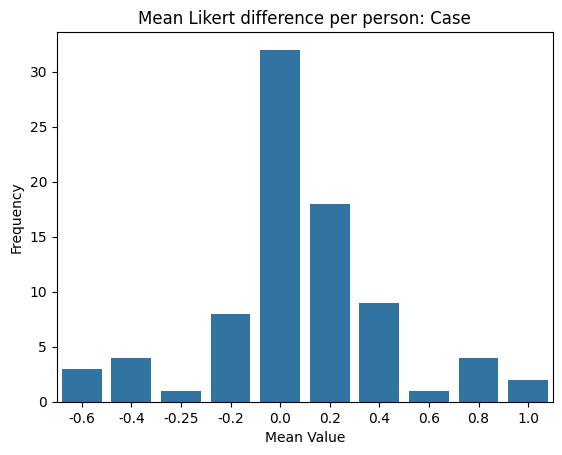

In [ ]:
#for initial likert values

playerIDs = all_df_players_network['playerId'].unique()

filtered_df_case = all_df_players_network[all_df_players_network['playerId'].isin(playerIDs)]

# Calculate the mean of the "Value" column for each ID
mean_values_initial_likert = filtered_df_case.groupby('playerId')['data.difference_likert'].mean().round(3).reset_index()

# Count the occurrences of each mean value
mean_value_counts = mean_values_initial_likert['data.difference_likert'].value_counts().reset_index()
mean_value_counts.columns = ['Mean Value', 'Frequency']

# Sort the DataFrame by the "Mean Value" column for plotting
mean_value_counts = mean_value_counts.sort_values(by='Mean Value')
print(mean_value_counts)

# Create a bar chart
sns.barplot(x='Mean Value', y='Frequency', data=mean_value_counts)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Mean Likert difference per person: Case')

# Display the chart
plt.show()

###Counting number of times each person was followed

####Functions

In [ ]:
def analyze_likert_responses(df, column_name, title, x):
    # Calculate Likert values counts and mean
    likert_counts = df[column_name].value_counts()
    mean_likert_counts_case = np.mean(df[column_name])
    print("Mean Likert Counts Case:", mean_likert_counts_case)

    # Calculate skewness
    skewness = stats.skew(df[column_name], bias=False)
    print("Skewness:", skewness)

    # Plot absolute frequency bar chart
    plot_bar(likert_counts.values, likert_counts.index,
             x, 'Count', title, 'Absolute')

    # Convert Likert responses to a sorted dictionary
    num_Likert = likert_counts.sort_index()
    print(num_Likert)
    num_Likert_dict = num_Likert.to_dict()

    # Calculate total responses and relative frequency
    total_responses = len(df[column_name])
    relative_frequency_likert = likert_counts / total_responses

    # Plot relative frequency bar chart
    plot_bar(relative_frequency_likert.values, relative_frequency_likert.index,
             x+'Proportion', 'Proportion', title, 'relative')

    # Convert relative frequency counts to a sorted dictionary
    likert_counts_dict = dict(sorted(relative_frequency_likert.to_dict().items()))

    return mean_likert_counts_case, skewness, num_Likert_dict, likert_counts_dict


In [ ]:
all_df_players_network.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   _id_x                                           410 non-null    object 
 1   batchId                                         410 non-null    object 
 2   playerId                                        410 non-null    object 
 3   roundId                                         410 non-null    object 
 4   gameId                                          410 non-null    object 
 5   createdAt_x                                     410 non-null    object 
 6   data.value                                      407 non-null    float64
 7   data.value_updated                              409 non-null    float64
 8   data.reason                                     381 non-null    object 
 9   data.reason_updated                        

In [ ]:
# # Assuming you have pandas imported and the DataFrame 'all_df_players_network' already defined
# import pandas as pd

# # Convert only the first 100 rows of the DataFrame to a CSV file
# all_df_players_network.head(100).to_csv('all_df_players_network_first_100.csv', index=False)


####Counting and data preprocessing

In [ ]:
#counting how many times every player was recommended
from collections import Counter

# Parse the 'data.followedPlayers' strings into lists of player IDs and convert them to integers
all_df_players_network['followedPlayersList'] = all_df_players_network['data.followedPlayers'].apply(
    lambda x: [int(i) for i in x.split(',')] if pd.notnull(x) else []
)

# Identify unique games
unique_games = all_df_players_network['gameId'].unique()

# Initialize dictionaries to keep track of players not followed in each round, for each game


# Assuming all_df_players_network is already defined and includes the 'followedPlayersList' column

# Initialize dictionaries to keep track of players not followed and followed count in each round, for each game
not_followed_in_each_round_game = {}
followed_count_in_each_round_game = {}  # New dictionary for followed counts

for game_id in unique_games:
    game_df = all_df_players_network[all_df_players_network['gameId'] == game_id]
    unique_rounds_in_game = game_df['round_index'].unique()

    not_followed_in_each_round = {}
    followed_count_in_each_round = {}  # To store followed counts for each round

    for round_id in unique_rounds_in_game:
        round_df = game_df[game_df['round_index'] == round_id]

        # Use a Counter to count followed players in the round
        followed_players_counter = Counter()
        for players_list in round_df['followedPlayersList']:
            followed_players_counter.update([int(player) for player in players_list])

        all_players_in_round_nodeID = set(round_df['data.nodeId'].apply(int))
        not_followed_players_nodeID = all_players_in_round_nodeID - set(followed_players_counter.keys())

        not_followed_in_each_round[round_id] = not_followed_players_nodeID
        followed_count_in_each_round[round_id] = followed_players_counter  # Store the counter for the round

    not_followed_in_each_round_game[game_id] = not_followed_in_each_round
    followed_count_in_each_round_game[game_id] = followed_count_in_each_round  # Store the counts for the game



In [ ]:
##Counts the number of times each of the players were recommended.
# Now I know how many times every player was recommended.
from collections import Counter


recommendation_counts_list = []

# Group by gameId and round_index
grouped = all_df_players_network.groupby(['gameId', 'round_index'])

for (game_id, round_index), group in grouped:
    # Process each group separately
    all_recommendations = group['data.player_specific_total_recommendation_list'].dropna().str.split(',')
    flattened_recommendations = [item for sublist in all_recommendations for item in sublist]
    recommendation_counts = Counter(flattened_recommendations)

    # For each game and round, store the recommendation count along with the gameId and round_index
    for player_id, count in recommendation_counts.items():
        recommendation_counts_list.append({
            'gameId': game_id,
            'round_index': round_index,
            'player_id': player_id,
            'RecommendationCount': count
        })

# Convert the list of dictionaries into a DataFrame
recommendation_counts_df = pd.DataFrame(recommendation_counts_list)

# Sort the DataFrame (optional, based on your needs)
recommendation_counts_df = recommendation_counts_df.sort_values(by=['gameId', 'round_index', 'player_id'], ascending=[True, True, True])

# Display the DataFrame
print(recommendation_counts_df)

                gameId  round_index player_id  RecommendationCount
6    CG7cWa4QWvsG9nxMu            0         0                    7
1    CG7cWa4QWvsG9nxMu            0         1                    8
4    CG7cWa4QWvsG9nxMu            0         2                    3
8    CG7cWa4QWvsG9nxMu            0         3                    6
0    CG7cWa4QWvsG9nxMu            0         4                    7
..                 ...          ...       ...                  ...
403  xzjPTkZ6udh5nRa6Y            4         5                    5
397  xzjPTkZ6udh5nRa6Y            4         6                    6
401  xzjPTkZ6udh5nRa6Y            4         7                    7
405  xzjPTkZ6udh5nRa6Y            4         8                    8
402  xzjPTkZ6udh5nRa6Y            4         9                    3

[410 rows x 4 columns]


##Isolation network
Isolation network is per round.

In [ ]:
print(not_followed_in_each_round_game)

{'CG7cWa4QWvsG9nxMu': {0: {8, 7}, 1: {8, 4}, 2: {4}, 3: set(), 4: {0}}, 'quFcEyR6pyBDjQeRj': {0: set(), 1: {8, 4}, 2: set(), 3: {8, 4}, 4: {4}}, 'pA8QEvxkstWdRQeAh': {0: set(), 1: set(), 2: {5}, 3: {5, 6}, 4: {9, 5, 6}}, 'iQgq9We48TWLZPXjh': {0: {21}, 1: {0, 21}, 2: {0}, 3: set(), 4: {5}}, 'xzjPTkZ6udh5nRa6Y': {0: {18}, 1: {17, 15}, 2: {15}, 3: {0, 1}, 4: {1}}}


In [ ]:
not_followed_subset_df = pd.DataFrame()

for key, value in not_followed_in_each_round_game.items():
    for sub_key, sub_value in value.items():
        if isinstance(sub_value, set):  # Check if sub_value is a set
            for element in sub_value:
                matching_rows = all_df_players_network[(all_df_players_network['gameId'] == key) & (all_df_players_network['round_index'] == sub_key) & (all_df_players_network['data.nodeId'] == element)]
                not_followed_subset_df = not_followed_subset_df.append(matching_rows, ignore_index=True)
                #not_followed_subset_df.append(matching_rows)



<ipython-input-35-89880fa7d256>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  not_followed_subset_df = not_followed_subset_df.append(matching_rows, ignore_index=True)


In [ ]:
# print(len(not_followed_subset_df))
# not_followed_subset_df.head()

In [ ]:
#MERGE WITH recommendation_counts_df with not_followed so that we can do different analysis with the not_followed_subset_df

not_followed_subset_df.rename(columns={'data.nodeId': 'player_id'}, inplace=True)

# Convert key columns in both DataFrames to strings to ensure matching types
not_followed_subset_df['gameId'] = not_followed_subset_df['gameId'].astype(str)
not_followed_subset_df['round_index'] = not_followed_subset_df['round_index'].astype(int)
not_followed_subset_df['player_id'] = not_followed_subset_df['player_id'].astype(int)

recommendation_counts_df['gameId'] = recommendation_counts_df['gameId'].astype(str)
recommendation_counts_df['round_index'] = recommendation_counts_df['round_index'].astype(int)
recommendation_counts_df['player_id'] = recommendation_counts_df['player_id'].astype(int)

# Now perform the merge
not_followed_subset_including_rec_df = pd.merge(recommendation_counts_df, not_followed_subset_df,
                     on=['gameId', 'round_index', 'player_id'],
                     how='inner')

# Display the merged DataFrame
len(not_followed_subset_including_rec_df)

#print(not_followed_subset_including_rec_df[['gameId', 'round_index', 'player_id', 'RecommendationCount']])

#Note, so those that got "isolated" were indeed recommended and NOT picked.

29

Mean Likert Counts Case: 3.392857142857143
Skewness: nan


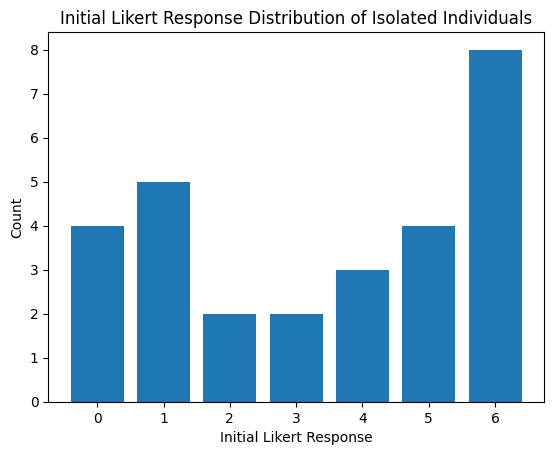

0.0    4
1.0    5
2.0    2
3.0    2
4.0    3
5.0    4
6.0    8
Name: data.value, dtype: int64


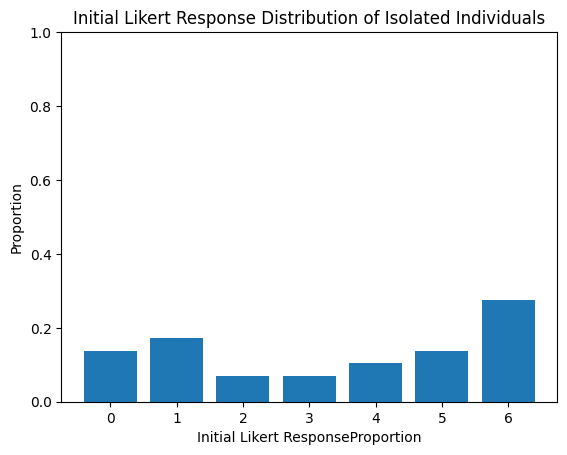

In [ ]:
##Checking likert values of those isolated
mean_initial_Likert_isolation, skewness_initial_Likert_isolation, likert_dict_initial_isolation, rel_freq_dict_initial_Likert_isolation = analyze_likert_responses(not_followed_subset_including_rec_df,
                                                                                                                                                                   'data.value', title='Initial Likert Response Distribution of Isolated Individuals',
                                                                                                                                                                   x='Initial Likert Response')


In [ ]:
## DO sth with the reasons
print(not_followed_subset_including_rec_df['data.reason'])

0     It will cost people more money to replace item...
1            we eon be able to continue on if we don't.
2     Both corporations and individuals contribute n...
3     They account for the vast majority of carbon e...
4     They have the means to help address climate ch...
5                                                   NaN
6     Let's avoid the desteuction of mankind at all ...
7                        Corporation is just part of it
8                                                   NaN
9     The rich is not the biggest contributor of cli...
10                                    They are selfish.
11                             they can so they should 
12                                                  yes
13    no, but there should be more green options ins...
14                                                  NaN
15    it will constantly maintain this way, though s...
16    Personally as someone who doesn't believe in t...
17    Neutral because it is not only caused by c

##Influencers network
This is per game.

In [ ]:
print(followed_count_in_each_round_game)

{'CG7cWa4QWvsG9nxMu': {0: Counter({1: 8, 5: 6, 0: 4, 2: 3, 3: 3, 6: 2, 4: 1}), 1: Counter({1: 8, 2: 6, 5: 6, 3: 2, 6: 2, 0: 2, 7: 1}), 2: Counter({2: 8, 1: 6, 5: 3, 8: 3, 3: 2, 7: 2, 0: 2, 6: 1}), 3: Counter({1: 7, 2: 5, 0: 4, 5: 3, 6: 3, 7: 2, 3: 1, 4: 1, 8: 1}), 4: Counter({1: 8, 4: 4, 7: 4, 6: 4, 5: 3, 2: 2, 3: 1, 8: 1})}, 'quFcEyR6pyBDjQeRj': {0: Counter({6: 7, 1: 6, 3: 5, 0: 5, 2: 3, 7: 3, 11: 2, 5: 2, 12: 2, 9: 2, 10: 2, 4: 1, 8: 1, 13: 1}), 1: Counter({1: 6, 0: 5, 11: 4, 3: 4, 9: 4, 6: 4, 7: 4, 5: 3, 2: 3, 12: 2, 13: 2, 10: 1}), 2: Counter({9: 5, 1: 4, 3: 4, 12: 4, 0: 4, 7: 4, 13: 4, 5: 3, 6: 3, 11: 2, 2: 2, 10: 1, 8: 1, 4: 1}), 3: Counter({3: 5, 12: 5, 9: 5, 7: 5, 5: 4, 6: 4, 13: 4, 1: 3, 0: 3, 11: 2, 10: 1, 2: 1}), 4: Counter({13: 6, 3: 5, 7: 5, 5: 4, 1: 4, 9: 4, 0: 4, 6: 3, 12: 2, 8: 2, 11: 1, 10: 1, 2: 1})}, 'pA8QEvxkstWdRQeAh': {0: Counter({4: 8, 2: 5, 7: 4, 12: 4, 13: 4, 3: 4, 10: 3, 0: 3, 6: 3, 14: 2, 11: 2, 1: 2, 8: 1, 9: 1, 15: 1, 5: 1}), 1: Counter({0: 7, 12: 6, 13: 5,

In [ ]:
# Initialize a dictionary to store the total followed count for each player in each game, sorted by player ID
total_followed_count_per_game_sorted = {}

for game_id, rounds in followed_count_in_each_round_game.items():
    # Initialize a Counter object for the game to aggregate counts across rounds
    game_total_followed_counter = Counter()

    for round_id, followed_counter in rounds.items():
        # Update the game's total followed counter with counts from this round
        game_total_followed_counter.update(followed_counter)

    # Sort the aggregated counts for the game by player ID before storing
    sorted_followed_counts = dict(sorted(game_total_followed_counter.items()))
    total_followed_count_per_game_sorted[game_id] = sorted_followed_counts

# Now, total_followed_count_per_game_sorted contains the sorted total number of times each player was followed in each game

# To display the result for each game, iterate over total_followed_count_per_game_sorted and its sorted counts
# for game_id, followed_counts in total_followed_count_per_game_sorted.items():
#     print(f"Game ID: {game_id}")
#     for player_id, count in followed_counts.items():
#         print(f"Player ID: {player_id} was followed {count} times in this game.")
#     print("\n")  # Newline for better readability between games

#Note, total_followed_count_per_game_sorted is a dictionary.

In [ ]:
# Aggregate RecommendationCount for each player across all rounds, for every game
aggregated_recommendation_counts_per_game = recommendation_counts_df.groupby(['gameId', 'player_id'])['RecommendationCount'].sum().reset_index()
aggregated_recommendation_counts_per_game.rename(columns={'RecommendationCount': 'TotalRecommendationsPerGame'}, inplace=True)

# Display the new DataFrame
print(aggregated_recommendation_counts_per_game)


               gameId  player_id  TotalRecommendationsPerGame
0   CG7cWa4QWvsG9nxMu          0                           32
1   CG7cWa4QWvsG9nxMu          1                           39
2   CG7cWa4QWvsG9nxMu          2                           31
3   CG7cWa4QWvsG9nxMu          3                           29
4   CG7cWa4QWvsG9nxMu          4                           31
..                ...        ...                          ...
77  xzjPTkZ6udh5nRa6Y         15                           24
78  xzjPTkZ6udh5nRa6Y         16                           24
79  xzjPTkZ6udh5nRa6Y         17                           23
80  xzjPTkZ6udh5nRa6Y         18                           23
81  xzjPTkZ6udh5nRa6Y         19                           32

[82 rows x 3 columns]


In [ ]:
print(total_followed_count_per_game_sorted)

{'CG7cWa4QWvsG9nxMu': {0: 12, 1: 37, 2: 24, 3: 9, 4: 6, 5: 21, 6: 12, 7: 9, 8: 5}, 'quFcEyR6pyBDjQeRj': {0: 21, 1: 23, 2: 10, 3: 23, 4: 2, 5: 16, 6: 21, 7: 21, 8: 4, 9: 20, 10: 6, 11: 11, 12: 15, 13: 17}, 'pA8QEvxkstWdRQeAh': {0: 31, 1: 14, 2: 15, 3: 15, 4: 18, 5: 2, 6: 10, 7: 8, 8: 10, 9: 4, 10: 19, 11: 17, 12: 31, 13: 17, 14: 11, 15: 12}, 'iQgq9We48TWLZPXjh': {0: 4, 1: 13, 2: 12, 3: 40, 4: 14, 5: 6, 6: 15, 7: 31, 8: 12, 9: 15, 10: 15, 11: 9, 12: 10, 13: 16, 14: 12, 15: 11, 16: 13, 17: 14, 18: 37, 19: 12, 20: 9, 21: 5, 22: 18}, 'xzjPTkZ6udh5nRa6Y': {0: 5, 1: 8, 2: 8, 3: 33, 4: 27, 5: 26, 6: 22, 7: 25, 8: 11, 9: 8, 10: 15, 11: 11, 12: 25, 13: 11, 14: 14, 15: 5, 16: 9, 17: 7, 18: 10, 19: 20}}


In [ ]:
data_for_df = []
for game_id, players in total_followed_count_per_game_sorted.items():
    for player_id, count in players.items():
        data_for_df.append({
            'gameId': game_id,
            'player_id': player_id,
            'total_followed_count_per_game_sorted': count  # Use an appropriate column name for the count from the nested dictionary
        })

# Convert the list of dictionaries into a DataFrame
nested_dict_df = pd.DataFrame(data_for_df)
total_followed_count_per_game_with_total_rec = pd.merge(aggregated_recommendation_counts_per_game, nested_dict_df, on=['gameId', 'player_id'], how='left')

# Calculate the ratio and create a new column with it
total_followed_count_per_game_with_total_rec['FollowSuccessRatio'] = total_followed_count_per_game_with_total_rec['total_followed_count_per_game_sorted'] / total_followed_count_per_game_with_total_rec['TotalRecommendationsPerGame']

# Display the updated DataFrame
#print(total_followed_count_per_game_with_total_rec)


In [ ]:
top_10_percent_df = pd.DataFrame()
bottom_10_percent_df = pd.DataFrame()

# Group by 'gameId' and process each group
for game_id, group in total_followed_count_per_game_with_total_rec.groupby('gameId'):
    # Calculate the 90th percentile for 'FollowSuccessRatio' within the current group
    percentile_90 = np.percentile(group['FollowSuccessRatio'], 90)
    # Filter the group to include only the top 10% of values
    top_10_percent_group = group[group['FollowSuccessRatio'] >= percentile_90]
    # Append the filtered group to the top_10_percent_df DataFrame
    top_10_percent_df = pd.concat([top_10_percent_df, top_10_percent_group])

    percentile_10 = np.percentile(group['FollowSuccessRatio'], 10)
    bottom_10_percent_group = group[group['FollowSuccessRatio'] <= percentile_10]
    bottom_10_percent_df = pd.concat([bottom_10_percent_df, bottom_10_percent_group])


# Reset index of the final DataFrame (optional, depending on your needs)
top_10_percent_df = top_10_percent_df.reset_index(drop=True)
bottom_10_percent_df = bottom_10_percent_df.reset_index(drop=True)

# Display or return the top 10% DataFrame
#print(top_10_percent_df)

In [ ]:
# Assuming top_10_percent_df and all_df_players_network have been loaded correctly
# Make sure gameId and playerId columns are named consistently and have compatible data types in both DataFrames

# Convert gameId and playerId to string if they are not already, to ensure compatibility
top_10_percent_df['gameId'] = top_10_percent_df['gameId'].astype(str)
top_10_percent_df['player_id'] = top_10_percent_df['player_id'].astype(int)
all_df_players_network['gameId'] = all_df_players_network['gameId'].astype(str)
all_df_players_network['data.nodeId'] = all_df_players_network['data.nodeId'].astype(float).astype(int)

top_10_percent_network= pd.merge(all_df_players_network, top_10_percent_df,  how='inner',
                                         left_on=['gameId', 'data.nodeId'],
                                         right_on=['gameId', 'player_id'])

#top_10_percent_network.head()

Mean Likert Counts Case: 4.5
Skewness: -1.006483820900831


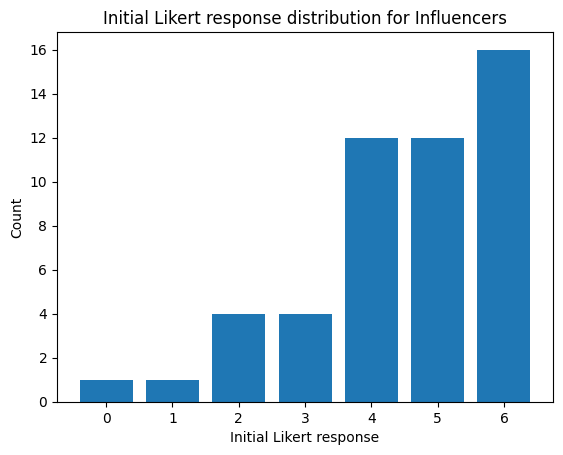

0.0     1
1.0     1
2.0     4
3.0     4
4.0    12
5.0    12
6.0    16
Name: data.value, dtype: int64


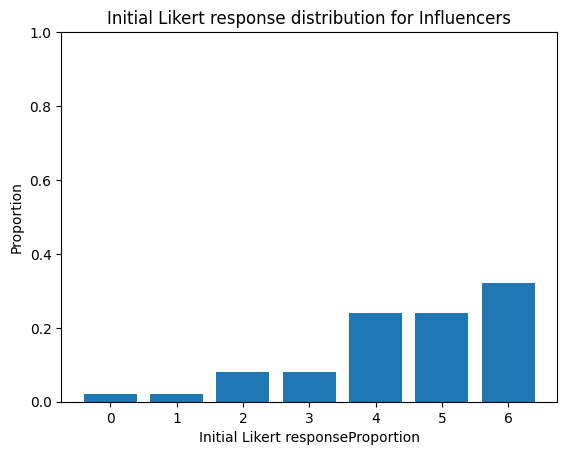

In [ ]:
mean_initial_Likert_influencer, skewness_initial_Likert_influencer, likert_dict_initial_influencer, rel_freq_dict_initial_Likert_influencer = analyze_likert_responses(top_10_percent_network, 'data.value', title='Initial Likert response distribution for Influencers', x='Initial Likert response')


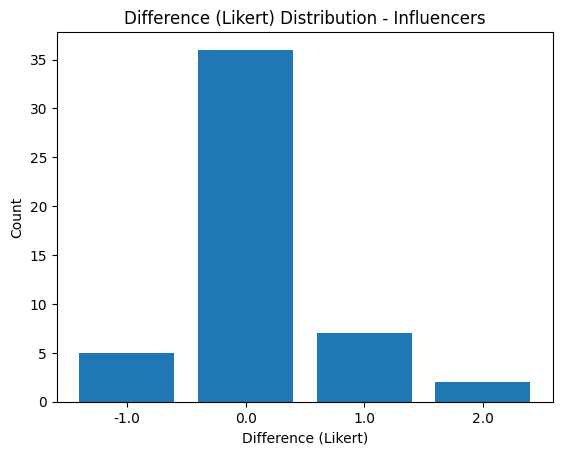

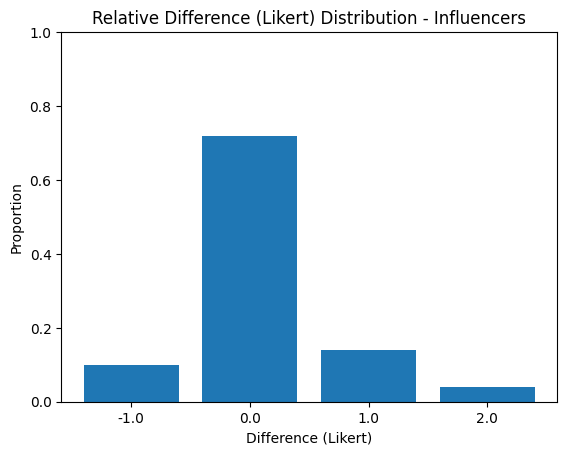

In [ ]:
def plot_bar_likert_diff(x, y, xlabel, ylabel, title, plot_type):
    plt.bar(x, y)  # x: categorical data, y: numerical data (heights of the bars)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if plot_type == 'relative':
        plt.ylim(0, 1)  # Set y-axis limits for relative frequency plots
    plt.show()

# Absolute Frequency Plot
difference_likert_counts = top_10_percent_network['data.difference_likert'].value_counts().sort_index()
plot_bar_likert_diff(difference_likert_counts.index.astype(str), difference_likert_counts.values,
         'Difference (Likert)', 'Count', 'Difference (Likert) Distribution - Influencers', 'absolute')

# Relative Frequency Plot
total_diff_likert_responses = len(top_10_percent_network['data.difference_likert'])
relative_frequency_diff_likert = difference_likert_counts / total_diff_likert_responses
plot_bar_likert_diff(relative_frequency_diff_likert.index.astype(str), relative_frequency_diff_likert.values,
         'Difference (Likert)', 'Proportion', 'Relative Difference (Likert) Distribution - Influencers', 'relative')


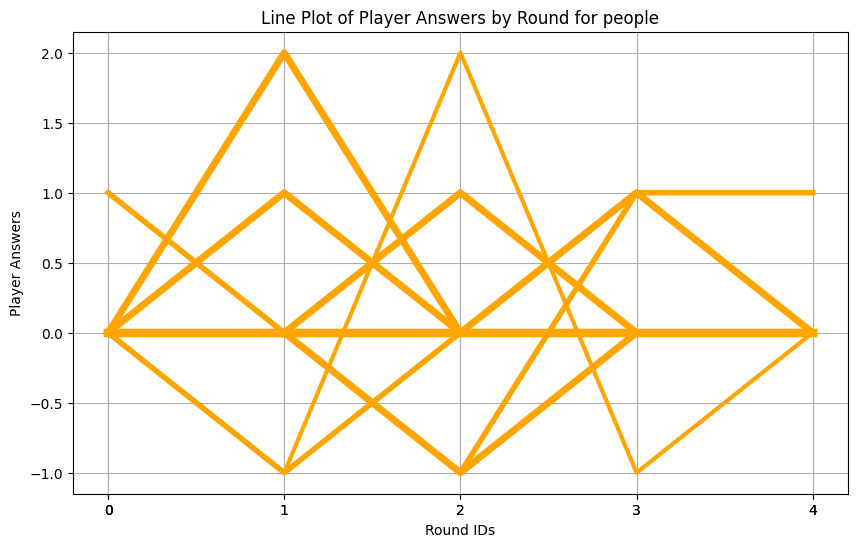

Variance for each round (all): round_index
0    0.100000
1    0.766667
2    0.766667
3    0.400000
4    0.100000
dtype: float64


In [ ]:
playerIDs = top_10_percent_network['playerId'].unique()

filtered_df = top_10_percent_network[top_10_percent_network['playerId'].isin(playerIDs)]

# Reshape the data to have one row per player per round
reshaped_df = filtered_df.pivot(index='playerId', columns='round_index', values='data.difference_likert')

plt.figure(figsize=(10, 6))

# Set a single color for all lines (e.g., blue)
line_color = 'orange'

# Iterate through each player to plot their answers as a line with a single color
for i, player in enumerate(reshaped_df.index):
    answers = reshaped_df.loc[player]

    # Calculate the line width based on the number of data points at each round
    line_width = [1 + answers.value_counts().get(round_id, 0) for round_id in answers.index]

    plt.plot(answers.index, answers.values, label=player, color=line_color, linewidth=max(line_width))

plt.xlabel('Round IDs')
plt.ylabel('Player Answers')
plt.title('Line Plot of Player Answers by Round for people')
plt.xticks([int(x) for x in plt.xticks()[0]])
#plt.legend()
plt.grid(True)
#plt.ylim(-4, 4)
# Show the line plot
plt.show()

# Calculate the variance for each round in the reshaped data
round_variances_all = reshaped_df.var()
print("Variance for each round (all):", round_variances_all)


##DE-Influencer Network

In [ ]:
# Assuming top_10_percent_df and all_df_players_network have been loaded correctly
# Make sure gameId and playerId columns are named consistently and have compatible data types in both DataFrames

# Convert gameId and playerId to string if they are not already, to ensure compatibility
bottom_10_percent_df['gameId'] = bottom_10_percent_df['gameId'].astype(str)
bottom_10_percent_df['player_id'] = bottom_10_percent_df['player_id'].astype(int)


bottom_10_percent_network= pd.merge(all_df_players_network, bottom_10_percent_df,  how='inner',
                                         left_on=['gameId', 'data.nodeId'],
                                         right_on=['gameId', 'player_id'])

len(bottom_10_percent_network)

50

Mean Likert Counts Case: 3.4285714285714284
Skewness: nan


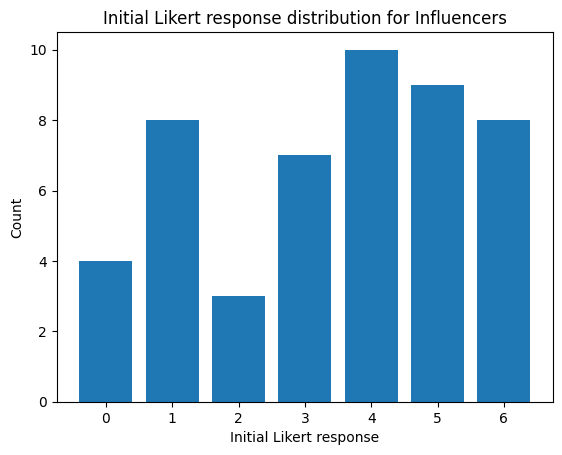

0.0     4
1.0     8
2.0     3
3.0     7
4.0    10
5.0     9
6.0     8
Name: data.value, dtype: int64


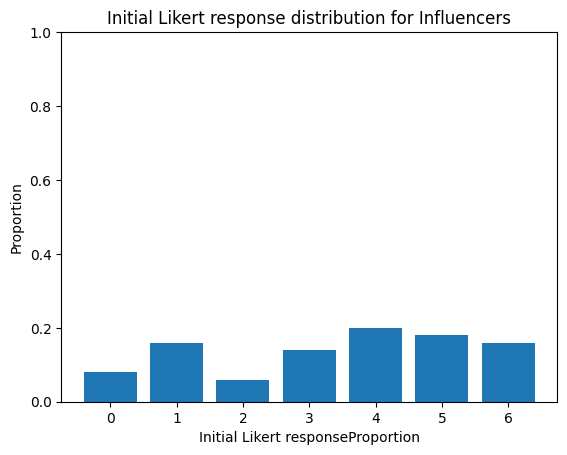

In [ ]:
mean_initial_Likert_deinfluencer, skewness_initial_Likert_deinfluencer, likert_dict_initial_deinfluencer, rel_freq_dict_initial_Likert_deinfluencer = analyze_likert_responses(bottom_10_percent_network, 'data.value', title='Initial Likert response distribution for Influencers', x='Initial Likert response')


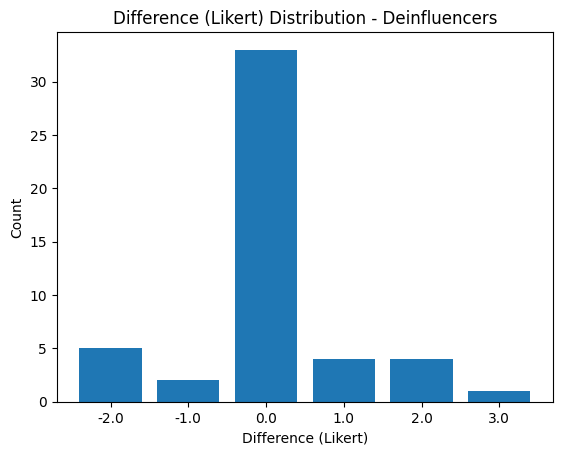

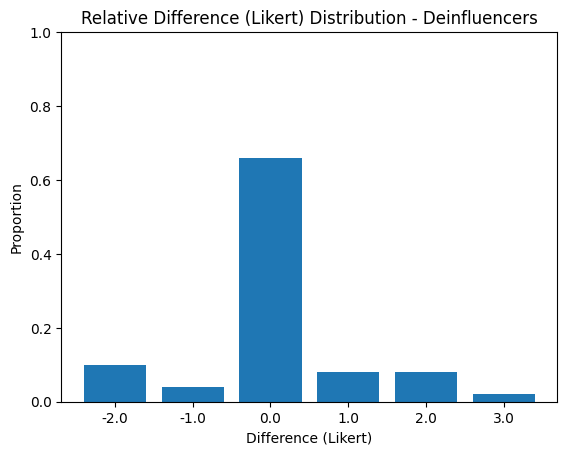

In [ ]:
# Absolute Frequency Plot
difference_likert_counts = bottom_10_percent_network['data.difference_likert'].value_counts().sort_index()
plot_bar_likert_diff(difference_likert_counts.index.astype(str), difference_likert_counts.values,
         'Difference (Likert)', 'Count', 'Difference (Likert) Distribution - Deinfluencers', 'absolute')

# Relative Frequency Plot
total_diff_likert_responses = len(bottom_10_percent_network['data.difference_likert'])
relative_frequency_diff_likert = difference_likert_counts / total_diff_likert_responses
plot_bar_likert_diff(relative_frequency_diff_likert.index.astype(str), relative_frequency_diff_likert.values,
         'Difference (Likert)', 'Proportion', 'Relative Difference (Likert) Distribution - Deinfluencers', 'relative')

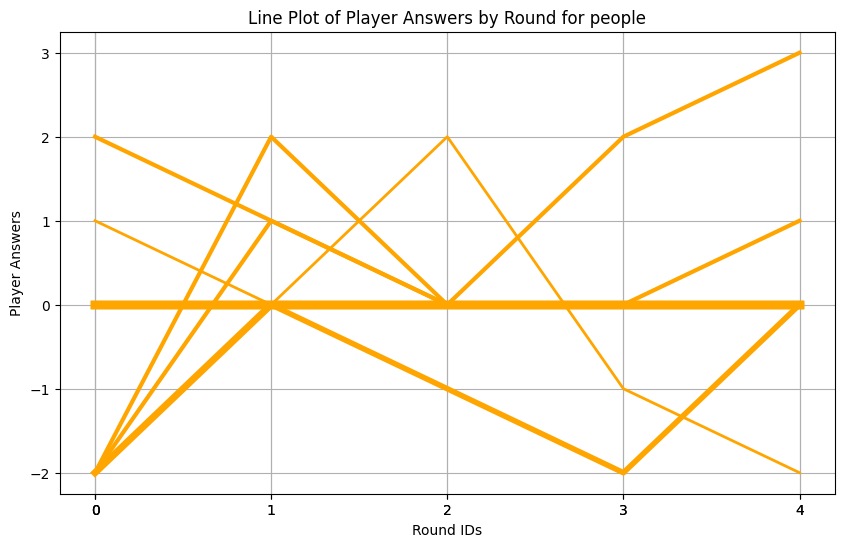

Variance for each round (all): round_index
0    1.788889
1    0.488889
2    0.544444
3    0.988889
4    1.694444
dtype: float64


In [ ]:
##ALL Players
playerIDs = bottom_10_percent_network['playerId'].unique()

filtered_df = bottom_10_percent_network[bottom_10_percent_network['playerId'].isin(playerIDs)]

# Reshape the data to have one row per player per round
reshaped_df = filtered_df.pivot(index='playerId', columns='round_index', values='data.difference_likert')

plt.figure(figsize=(10, 6))

# Set a single color for all lines (e.g., blue)
line_color = 'orange'

# Iterate through each player to plot their answers as a line with a single color
for i, player in enumerate(reshaped_df.index):
    answers = reshaped_df.loc[player]

    # Calculate the line width based on the number of data points at each round
    line_width = [1 + answers.value_counts().get(round_id, 0) for round_id in answers.index]

    plt.plot(answers.index, answers.values, label=player, color=line_color, linewidth=max(line_width))

plt.xlabel('Round IDs')
plt.ylabel('Player Answers')
plt.title('Line Plot of Player Answers by Round for people')
plt.xticks([int(x) for x in plt.xticks()[0]])
#plt.legend()
plt.grid(True)
#plt.ylim(-4, 4)
# Show the line plot
plt.show()

# Calculate the variance for each round in the reshaped data
round_variances_all = reshaped_df.var()
print("Variance for each round (all):", round_variances_all)
